top 50 proteins

In [23]:
"""
Contrastive spectrum → Accession search engine on combined_annotated_filtered.h5

Now restricted to the TOP 50 most frequent accessions.

H5 keys:
 - Accession
 - MASS
 - PFR
 - file_name
 - group_name
 - ms2_lib
 - precursor_mz
 - rt_min
 - scan
 - sequence
"""

import os
import h5py
import numpy as np
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler

# =========================
# 0. Config
# =========================
H5_PATH         = r"F:\20251115\spectra_h5\combined_annotated_filtered.h5"
DEVICE          = "cuda" if torch.cuda.is_available() else "cpu"

EMB_DIM         = 64           # embedding dimension
BATCH_P_CLASSES = 32          # number of accessions per batch
BATCH_K_SPECTRA = 4           # spectra per accession per batch
EPOCHS          = 10
LR              = 1e-3
TEMPERATURE     = 0.07
MAX_SPECTRA     = None        # optional subsampling BEFORE top-50 filter

K_NEIGHBORS     = 10          # for Top-K eval
TOP_K_CLASSES   = 50          # *** top 50 accessions ***
RANDOM_SEED     = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


# =========================
# 1. Load & initial clean
# =========================
print("Loading HDF5:", H5_PATH)
with h5py.File(H5_PATH, "r") as h5:
    acc_raw = h5["Accession"][:]   # dtype=object
    ms2_lib = h5["ms2_lib"][:]     # (N, n_bins)

# Decode accessions
acc_str = np.array([
    a.decode() if isinstance(a, (bytes, bytearray)) else str(a)
    for a in acc_raw
])

# Filter out empty accessions
mask_nonempty = acc_str != ""
acc_str = acc_str[mask_nonempty]
ms2_lib = ms2_lib[mask_nonempty]

print("Total spectra after filtering empty accessions:", len(acc_str))

# Optional subsampling (before top-50 filter)
if MAX_SPECTRA is not None and MAX_SPECTRA < len(acc_str):
    idx_sub = np.random.choice(len(acc_str), size=MAX_SPECTRA, replace=False)
    acc_str = acc_str[idx_sub]
    ms2_lib = ms2_lib[idx_sub]
    print(f"Subsampled to {len(acc_str)} spectra before top-50 filter")

# Convert spectra to float32 and clean NaN / inf
ms2_lib = ms2_lib.astype(np.float32)
bad_mask = ~np.isfinite(ms2_lib)
if bad_mask.any():
    print("Found NaN/inf in ms2_lib, replacing with 0")
    ms2_lib[bad_mask] = 0.0

# Per-spectrum max normalization
max_intensity = np.max(ms2_lib, axis=1, keepdims=True)
max_intensity[max_intensity == 0] = 1.0
ms2_lib = ms2_lib / max_intensity

print("Any NaN left in ms2_lib?", np.isnan(ms2_lib).any())
print("Any inf left in ms2_lib?", np.isinf(ms2_lib).any())

N_total, n_bins = ms2_lib.shape
print(f"Spectra shape before top-50 filter: (N, n_bins) = {ms2_lib.shape}")


# =========================
# 2. Restrict to TOP 50 accessions
# =========================
# First, encode all accessions & count
all_unique_acc, all_acc_ids = np.unique(acc_str, return_inverse=True)
counts = np.bincount(all_acc_ids)
print("Total unique accessions before top-50 filter:", len(all_unique_acc))

# Get indices of top-50 classes by count
top_k = min(TOP_K_CLASSES, len(all_unique_acc))
top_class_indices = np.argsort(-counts)[:top_k]   # descending
top_class_set = set(top_class_indices.tolist())

print(f"Using top {top_k} accessions by frequency.")

# Filter spectra to only these top classes
mask_top = np.isin(all_acc_ids, list(top_class_set))
acc_str_top = acc_str[mask_top]
ms2_lib_top = ms2_lib[mask_top]
acc_ids_top_raw = all_acc_ids[mask_top]

print("Spectra after top-50 filter:", len(acc_str_top))

# Re-encode labels compactly 0..(K-1)
unique_acc_top, acc_ids_top = np.unique(acc_str_top, return_inverse=True)
n_classes = len(unique_acc_top)
print("Number of unique accessions after top-50 filter:", n_classes)

N, n_bins = ms2_lib_top.shape
print(f"Final spectra shape: (N, n_bins) = {ms2_lib_top.shape}")


# =========================
# 3. Train / test split on filtered data
# =========================
indices = np.arange(N)
np.random.shuffle(indices)
split = int(0.8 * N)
train_idx = indices[:split]
test_idx  = indices[split:]

train_ms2   = ms2_lib_top[train_idx]
train_accid = acc_ids_top[train_idx]

test_ms2    = ms2_lib_top[test_idx]
test_accid  = acc_ids_top[test_idx]

print(f"Train spectra: {len(train_ms2)}, Test spectra: {len(test_ms2)}")


# =========================
# 4. Dataset & balanced sampler
# =========================
class SpectraDataset(Dataset):
    def __init__(self, ms2, accid):
        self.ms2   = torch.tensor(ms2,   dtype=torch.float32)
        self.accid = torch.tensor(accid, dtype=torch.long)

    def __len__(self):
        return self.ms2.shape[0]

    def __getitem__(self, idx):
        return {
            "spectrum": self.ms2[idx],
            "accid":    self.accid[idx]
        }


class ClassBalancedBatchSampler(Sampler):
    """
    Samples batches with:
      - classes_per_batch distinct accessions
      - samples_per_class spectra for each accession
    """
    def __init__(self, labels, classes_per_batch=32, samples_per_class=4):
        self.labels = np.array(labels, dtype=np.int64)
        self.classes_per_batch = classes_per_batch
        self.samples_per_class = samples_per_class

        self.class_to_indices = defaultdict(list)
        for i, lab in enumerate(self.labels):
            self.class_to_indices[lab].append(i)

        self.unique_classes = np.array(list(self.class_to_indices.keys()))
        self.batch_size = self.classes_per_batch * self.samples_per_class

    def __iter__(self):
        while True:
            if len(self.unique_classes) <= self.classes_per_batch:
                chosen_classes = self.unique_classes
            else:
                chosen_classes = np.random.choice(
                    self.unique_classes,
                    size=self.classes_per_batch,
                    replace=False
                )

            batch_indices = []
            for c in chosen_classes:
                idxs = self.class_to_indices[c]
                if len(idxs) >= self.samples_per_class:
                    chosen = np.random.choice(idxs, size=self.samples_per_class, replace=False)
                else:
                    chosen = np.random.choice(idxs, size=self.samples_per_class, replace=True)
                batch_indices.extend(chosen.tolist())
            yield batch_indices

    def __len__(self):
        # approximate number of batches per epoch
        return max(1, len(self.labels) // self.batch_size)


train_dataset = SpectraDataset(train_ms2, train_accid)
train_sampler = ClassBalancedBatchSampler(
    labels=train_accid,
    classes_per_batch=BATCH_P_CLASSES,
    samples_per_class=BATCH_K_SPECTRA
)
train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler
)


# =========================
# 5. Model
# =========================
class SpectrumEncoder(nn.Module):
    def __init__(self, n_bins, emb_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_bins, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, emb_dim),
        )

    def forward(self, x):
        z = self.net(x)
        if torch.isnan(z).any():
            print("Warning: NaN detected in encoder output, applying nan_to_num.")
            z = torch.nan_to_num(z, nan=0.0, posinf=1e6, neginf=-1e6)
        z = F.normalize(z, dim=-1)
        return z


# =========================
# 6. Safe supervised contrastive loss
# =========================
def supervised_contrastive_loss_safe(emb, labels, temperature=0.07):
    """
    emb    : (B, D) L2-normalized embeddings
    labels : (B,) int accession ids
    """
    device = emb.device
    B, D = emb.shape
    if B <= 1:
        return torch.tensor(0.0, device=device)

    # Cosine similarity
    sim = emb @ emb.t()
    sim = torch.clamp(sim / temperature, min=-50.0, max=50.0)

    total_loss = 0.0
    valid_anchors = 0

    for i in range(B):
        sim_i = sim[i].clone()
        sim_i[i] = float("-inf")

        pos_mask_i = (labels == labels[i]) & (torch.arange(B, device=device) != i)
        if not pos_mask_i.any():
            continue

        finite_mask = torch.isfinite(sim_i)
        if not finite_mask.any():
            continue

        max_sim = sim_i[finite_mask].max()
        shifted = sim_i - max_sim
        shifted[~finite_mask] = float("-inf")

        exp_all = torch.exp(shifted)
        denom = exp_all.sum()
        if not torch.isfinite(denom) or denom <= 0:
            continue

        exp_pos = exp_all * pos_mask_i.float()
        num = exp_pos.sum()
        if not torch.isfinite(num) or num <= 0:
            continue

        loss_i = -torch.log(num / denom)
        if not torch.isfinite(loss_i):
            continue

        total_loss += loss_i
        valid_anchors += 1

    if valid_anchors == 0:
        return torch.tensor(0.0, device=device)

    loss = total_loss / valid_anchors
    return loss


# =========================
# 7. Training loop
# =========================
model = SpectrumEncoder(n_bins=n_bins, emb_dim=EMB_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

steps_per_epoch = len(train_loader)
print("steps_per_epoch:", steps_per_epoch)

# Sanity check
print("Running a sanity check on one batch...")
batch_example = next(iter(train_loader))
x_ex = batch_example["spectrum"].to(DEVICE)
y_ex = batch_example["accid"].to(DEVICE)
with torch.no_grad():
    emb_ex = model(x_ex)
    print("Any NaN in emb_ex?", torch.isnan(emb_ex).any().item())
    loss_ex = supervised_contrastive_loss_safe(emb_ex, y_ex, temperature=TEMPERATURE)
    print("Initial loss (sanity check):", loss_ex.item())

print("Starting training...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    effective_steps = 0

    for step, batch in enumerate(train_loader):
        if step >= steps_per_epoch:
            break  # prevent infinite epoch

        x = batch["spectrum"].to(DEVICE)
        y = batch["accid"].to(DEVICE)

        emb = model(x)
        loss = supervised_contrastive_loss_safe(emb, y, temperature=TEMPERATURE)

        if torch.isnan(loss) or not torch.isfinite(loss):
            print(f"NaN/inf loss at epoch {epoch+1}, step {step+1}. Skipping.")
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        effective_steps += 1

        if (step + 1) % 100 == 0:
            avg_loss = running_loss / max(1, effective_steps)
            print(f"Epoch {epoch+1} Step {step+1}/{steps_per_epoch}  Loss: {avg_loss:.4f}")

    avg_loss = running_loss / max(1, effective_steps)
    print(f"Epoch {epoch+1} completed. Avg loss over valid steps: {avg_loss:.4f}")

print("Training done.")


# =========================
# 8. Build train embedding index
# =========================
model.eval()
with torch.no_grad():
    train_emb = []
    batch_size_eval = 2048
    for i in range(0, len(train_ms2), batch_size_eval):
        batch = torch.tensor(
            train_ms2[i:i+batch_size_eval],
            dtype=torch.float32,
            device=DEVICE
        )
        z = model(batch)
        train_emb.append(z.cpu().numpy())
    train_emb = np.concatenate(train_emb, axis=0)

print("Train embeddings shape:", train_emb.shape)
train_labels = train_accid


# =========================
# 9. k-NN search & evaluation
# =========================
def cosine_knn(query_emb, db_emb, db_labels, k=10):
    sims = db_emb @ query_emb
    k = min(k, len(db_emb))
    topk_idx = np.argpartition(-sims, k-1)[:k]
    topk_idx = topk_idx[np.argsort(-sims[topk_idx])]
    return topk_idx, sims[topk_idx], db_labels[topk_idx]


print("Evaluating on test set...")
correct_top1 = 0
correct_topk = 0
total = len(test_ms2)

accid_to_acc = {i: acc for i, acc in enumerate(unique_acc_top)}

with torch.no_grad():
    batch_size_eval = 512
    for i in range(0, len(test_ms2), batch_size_eval):
        batch_ms2   = test_ms2[i:i+batch_size_eval]
        batch_label = test_accid[i:i+batch_size_eval]

        batch = torch.tensor(batch_ms2, dtype=torch.float32, device=DEVICE)
        z = model(batch).cpu().numpy()

        for j in range(z.shape[0]):
            q_emb = z[j]
            true_label = batch_label[j]

            idxs, sims, lbls = cosine_knn(q_emb, train_emb, train_labels, k=K_NEIGHBORS)

            if lbls[0] == true_label:
                correct_top1 += 1

            if true_label in lbls:
                correct_topk += 1

top1_acc = correct_top1 / total
topk_acc = correct_topk / total

print(f"Test Top-1 accuracy (top {n_classes} accessions): {top1_acc:.4f}")
print(f"Test Top-{K_NEIGHBORS} accuracy: {topk_acc:.4f}")


# =========================
# 10. Example predictions
# =========================
print("\nExample predictions (restricted to top 50 accessions):")
num_examples = min(5, len(test_ms2))
for idx in range(num_examples):
    x = torch.tensor(test_ms2[idx:idx+1], dtype=torch.float32, device=DEVICE)
    with torch.no_grad():
        zq = model(x).cpu().numpy()[0]
    idxs, sims, lbls = cosine_knn(zq, train_emb, train_labels, k=K_NEIGHBORS)

    true_acc = accid_to_acc[int(test_accid[idx])]
    print(f"Test spectrum {idx}: true accession = {true_acc}")
    print("  Nearest accessions:")
    for l, s in zip(lbls[:5], sims[:5]):
        print(f"    {accid_to_acc[int(l)]}  (sim={s:.3f})")
    print("")


Loading HDF5: F:\20251115\spectra_h5\combined_annotated_filtered.h5
Total spectra after filtering empty accessions: 398060
Any NaN left in ms2_lib? False
Any inf left in ms2_lib? False
Spectra shape before top-50 filter: (N, n_bins) = (398060, 1600)
Total unique accessions before top-50 filter: 1815
Using top 50 accessions by frequency.
Spectra after top-50 filter: 305571
Number of unique accessions after top-50 filter: 50
Final spectra shape: (N, n_bins) = (305571, 1600)
Train spectra: 244456, Test spectra: 61115
steps_per_epoch: 1909
Running a sanity check on one batch...
Any NaN in emb_ex? False
Initial loss (sanity check): 3.6787078380584717
Starting training...
Epoch 1 Step 100/1909  Loss: 1.4508
Epoch 1 Step 200/1909  Loss: 1.1146
Epoch 1 Step 300/1909  Loss: 0.9532
Epoch 1 Step 400/1909  Loss: 0.8497
Epoch 1 Step 500/1909  Loss: 0.7797
Epoch 1 Step 600/1909  Loss: 0.7251
Epoch 1 Step 700/1909  Loss: 0.6796
Epoch 1 Step 800/1909  Loss: 0.6432
Epoch 1 Step 900/1909  Loss: 0.6140
E

Save the model

In [26]:
MODEL_PATH = "contrastive_spectrum_encoder.pth"

torch.save({
    "model_state_dict": model.state_dict(),
    "emb_dim": EMB_DIM,
    "n_bins": n_bins,
    # convert to plain Python list of strings
    "unique_acc_top": list(unique_acc_top),
}, MODEL_PATH)

print(f"Model saved to {MODEL_PATH}")


Model saved to contrastive_spectrum_encoder.pth


Embedding visualization

In [30]:
"""
Evaluate contrastive spectrum → accession search engine
for top 50 accessions, with SEPARATE timing for embedding and k-NN.

Assumes you have already trained and saved a model to:
    contrastive_spectrum_encoder.pth

Checkpoint format is expected to contain at least:
    - "model_state_dict"
    - "emb_dim"

HDF5 keys:
 - Accession
 - MASS
 - PFR
 - file_name
 - group_name
 - ms2_lib
 - precursor_mz
 - rt_min
 - scan
 - sequence
"""

import os
import time
import h5py
import numpy as np
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F

# =========================
# CONFIG
# =========================
H5_PATH         = r"F:\20251115\spectra_h5\combined_annotated_filtered.h5"
MODEL_PATH      = "contrastive_spectrum_encoder.pth"

DEVICE          = "cuda" if torch.cuda.is_available() else "cpu"

TOP_K_CLASSES   = 50      # top 50 accessions by frequency
K_NEIGHBORS     = 10      # for Top-K accuracy and kNN timing
N_PER_CLASS     = 100     # number of test examples per accession (max)
RANDOM_SEED     = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("Using device:", DEVICE)

# =========================
# 1) Load & clean HDF5
# =========================
print("Loading HDF5:", H5_PATH)
with h5py.File(H5_PATH, "r") as h5:
    acc_raw = h5["Accession"][:]   # dtype=object
    ms2_lib = h5["ms2_lib"][:]     # (N, n_bins)

# Decode accessions
acc_str = np.array([
    a.decode() if isinstance(a, (bytes, bytearray)) else str(a)
    for a in acc_raw
])

# Filter out empty accessions
mask_nonempty = acc_str != ""
acc_str = acc_str[mask_nonempty]
ms2_lib = ms2_lib[mask_nonempty]

print("Total spectra after filtering empty accessions:", len(acc_str))

# Clean spectra
ms2_lib = ms2_lib.astype(np.float32)
bad_mask = ~np.isfinite(ms2_lib)
if bad_mask.any():
    print("Found NaN/inf in ms2_lib, replacing with 0")
    ms2_lib[bad_mask] = 0.0

# Per-spectrum max normalization (same as during training)
max_intensity = np.max(ms2_lib, axis=1, keepdims=True)
max_intensity[max_intensity == 0] = 1.0
ms2_lib = ms2_lib / max_intensity

print("Any NaN left in ms2_lib?", np.isnan(ms2_lib).any())
print("Any inf left in ms2_lib?", np.isinf(ms2_lib).any())
N_total, n_bins = ms2_lib.shape
print(f"Spectra shape (N, n_bins) = {ms2_lib.shape}")

# =========================
# 2) Restrict to top-50 accessions
# =========================
all_unique_acc, all_acc_ids = np.unique(acc_str, return_inverse=True)
counts = np.bincount(all_acc_ids)
print("Total unique accessions before top-50 filter:", len(all_unique_acc))

top_k = min(TOP_K_CLASSES, len(all_unique_acc))
top_class_indices = np.argsort(-counts)[:top_k]  # indices of most frequent classes
top_class_set = set(top_class_indices.tolist())

print(f"Using top {top_k} accessions by frequency.")

mask_top = np.isin(all_acc_ids, list(top_class_set))
acc_str_top = acc_str[mask_top]
ms2_lib_top = ms2_lib[mask_top]

print("Spectra after top-50 filter:", len(acc_str_top))

# Re-encode labels compactly 0..(n_classes-1) based on accession strings
unique_acc_top, acc_ids_top = np.unique(acc_str_top, return_inverse=True)
n_classes = len(unique_acc_top)
print("Number of unique accessions after top-50 filter:", n_classes)

N, n_bins = ms2_lib_top.shape
print(f"Final spectra shape (N, n_bins) = {ms2_lib_top.shape}")

# =========================
# 3) Train / test split (80/20 for evaluation)
# =========================
indices = np.arange(N)
np.random.shuffle(indices)
split = int(0.8 * N)
train_idx = indices[:split]
test_idx  = indices[split:]

train_ms2   = ms2_lib_top[train_idx]
train_accid = acc_ids_top[train_idx]

test_ms2    = ms2_lib_top[test_idx]
test_accid  = acc_ids_top[test_idx]

print(f"Train spectra: {len(train_ms2)}, Test spectra: {len(test_ms2)}")

# =========================
# 4) Define model & load checkpoint
# =========================
class SpectrumEncoder(nn.Module):
    def __init__(self, n_bins, emb_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_bins, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, emb_dim),
        )

    def forward(self, x):
        z = self.net(x)
        # Safety guard
        if torch.isnan(z).any():
            print("Warning: NaN detected in encoder output, applying nan_to_num.")
            z = torch.nan_to_num(z, nan=0.0, posinf=1e6, neginf=-1e6)
        z = F.normalize(z, dim=-1)
        return z

print("\nLoading trained model from:", MODEL_PATH)
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=False)

emb_dim_ckpt = checkpoint["emb_dim"]
print("Embedding dimension from checkpoint:", emb_dim_ckpt)

loaded_model = SpectrumEncoder(n_bins=n_bins, emb_dim=emb_dim_ckpt).to(DEVICE)
loaded_model.load_state_dict(checkpoint["model_state_dict"])
loaded_model.eval()
print("Model loaded and set to eval mode.")

# =========================
# 5) Build train embedding index
# =========================
def embed_batch(model, spectra_np, device, batch_size=2048):
    out = []
    with torch.no_grad():
        for i in range(0, len(spectra_np), batch_size):
            xb = torch.tensor(
                spectra_np[i:i+batch_size],
                dtype=torch.float32,
                device=device
            )
            zb = model(xb)
            out.append(zb.cpu().numpy())
    return np.concatenate(out, axis=0)

print("\nEmbedding all train spectra for index...")
train_emb = embed_batch(loaded_model, train_ms2, DEVICE, batch_size=2048)
train_labels = train_accid.copy()
print("Train embeddings shape:", train_emb.shape)

# =========================
# 6) k-NN helper
# =========================
def cosine_knn(query_emb, db_emb, db_labels, k=10):
    """
    query_emb: (D,) numpy array
    db_emb   : (N, D)
    db_labels: (N,)
    """
    sims = db_emb @ query_emb
    k = min(k, len(db_emb))
    topk_idx = np.argpartition(-sims, k-1)[:k]
    topk_idx = topk_idx[np.argsort(-sims[topk_idx])]
    return topk_idx, sims[topk_idx], db_labels[topk_idx]

# =========================
# 7) GPU warm-up for timing
# =========================
print("\nWarming up model and kNN for timing...")
if len(train_ms2) > 0:
    warm_batch = torch.tensor(
        train_ms2[:min(32, len(train_ms2))],
        dtype=torch.float32,
        device=DEVICE
    )
    with torch.no_grad():
        for _ in range(10):
            _ = loaded_model(warm_batch)
    if DEVICE == "cuda":
        torch.cuda.synchronize()

    # Warm up kNN on a random vector
    dummy_vec = np.random.randn(train_emb.shape[1]).astype(np.float32)
    _ = train_emb @ dummy_vec

print("Warm-up done.\n")

# =========================
# 8) Evaluate per accession (100 examples each) with SEPARATE timing
# =========================
print("Evaluating per accession (up to 100 test spectra each)...\n")

overall_correct_top1 = 0
overall_correct_topk = 0
overall_total = 0

overall_time_embed = 0.0   # only model forward
overall_time_knn   = 0.0   # only cosine kNN

results = []

for acc_id in range(n_classes):
    acc_name = unique_acc_top[acc_id]

    # All test indices for this accession
    idxs = np.where(test_accid == acc_id)[0]
    if len(idxs) == 0:
        print(f"{acc_name:20s} | no test spectra, skipping")
        continue

    # Sample up to N_PER_CLASS indices
    if len(idxs) > N_PER_CLASS:
        idxs = np.random.choice(idxs, size=N_PER_CLASS, replace=False)

    correct_top1 = 0
    correct_topk = 0
    total = len(idxs)

    time_embed_acc = 0.0
    time_knn_acc   = 0.0

    for i in idxs:
        spectrum_np = test_ms2[i]

        # ---------- measure EMBEDDING time ----------
        with torch.no_grad():
            x = torch.tensor(
                spectrum_np[None, :],
                dtype=torch.float32,
                device=DEVICE
            )

            t0_embed = time.time()
            z = loaded_model(x)
            if DEVICE == "cuda":
                torch.cuda.synchronize()
            t1_embed = time.time()

        z_np = z.cpu().numpy()[0]
        embed_elapsed = t1_embed - t0_embed
        time_embed_acc += embed_elapsed
        overall_time_embed += embed_elapsed

        # ---------- measure k-NN time (CPU) ----------
        t0_knn = time.time()
        _, _, lbls = cosine_knn(z_np, train_emb, train_labels, k=K_NEIGHBORS)
        t1_knn = time.time()

        knn_elapsed = t1_knn - t0_knn
        time_knn_acc += knn_elapsed
        overall_time_knn += knn_elapsed

        true_label = test_accid[i]

        # Top-1
        if lbls[0] == true_label:
            correct_top1 += 1

        # Top-K
        if true_label in lbls:
            correct_topk += 1

    overall_correct_top1 += correct_top1
    overall_correct_topk += correct_topk
    overall_total += total

    top1 = correct_top1 / total
    topk = correct_topk / total

    avg_embed_ms = (time_embed_acc / total) * 1000.0
    avg_knn_ms   = (time_knn_acc   / total) * 1000.0

    results.append((acc_name, total, top1, topk, avg_embed_ms, avg_knn_ms))
    print(
        f"{acc_name:20s} | n={total:3d} | "
        f"Top-1={top1:.3f} | Top-{K_NEIGHBORS}={topk:.3f} | "
        f"embed={avg_embed_ms:.3f} ms | kNN={avg_knn_ms:.3f} ms"
    )

# =========================
# 9) Overall stats (separate embed + kNN)
# =========================
print("\n===============================================")
if overall_total > 0:
    overall_top1 = overall_correct_top1 / overall_total
    overall_topk = overall_correct_topk / overall_total
    overall_avg_embed_ms = (overall_time_embed / overall_total) * 1000.0
    overall_avg_knn_ms   = (overall_time_knn   / overall_total) * 1000.0
    overall_avg_total_ms = overall_avg_embed_ms + overall_avg_knn_ms

    print(f"Overall (top {n_classes} accessions, up to {N_PER_CLASS} tests each):")
    print(f"Top-1 Accuracy               = {overall_top1:.4f}")
    print(f"Top-{K_NEIGHBORS} Accuracy        = {overall_topk:.4f}")
    print(f"Avg embedding latency        = {overall_avg_embed_ms:.3f} ms")
    print(f"Avg k-NN latency             = {overall_avg_knn_ms:.3f} ms")
    print(f"Avg total latency (embed+kNN)= {overall_avg_total_ms:.3f} ms")
else:
    print("No test spectra available for evaluation.")
print("===============================================\n")


Using device: cpu
Loading HDF5: F:\20251115\spectra_h5\combined_annotated_filtered.h5
Total spectra after filtering empty accessions: 398060
Any NaN left in ms2_lib? False
Any inf left in ms2_lib? False
Spectra shape (N, n_bins) = (398060, 1600)
Total unique accessions before top-50 filter: 1815
Using top 50 accessions by frequency.
Spectra after top-50 filter: 305571
Number of unique accessions after top-50 filter: 50
Final spectra shape (N, n_bins) = (305571, 1600)
Train spectra: 244456, Test spectra: 61115

Loading trained model from: contrastive_spectrum_encoder.pth
Embedding dimension from checkpoint: 64
Model loaded and set to eval mode.

Embedding all train spectra for index...
Train embeddings shape: (244456, 64)

Warming up model and kNN for timing...
Warm-up done.

Evaluating per accession (up to 100 test spectra each)...

O14558               | n=100 | Top-1=0.990 | Top-10=0.990 | embed=3.791 ms | kNN=13.418 ms
O75964               | n=100 | Top-1=0.950 | Top-10=0.970 | embe

Visualizing 8000 points out of 244456 total.
Running PCA...
Running PCA->t-SNE (this can take a bit)...


c:\Users\benja\miniconda3\envs\vae\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


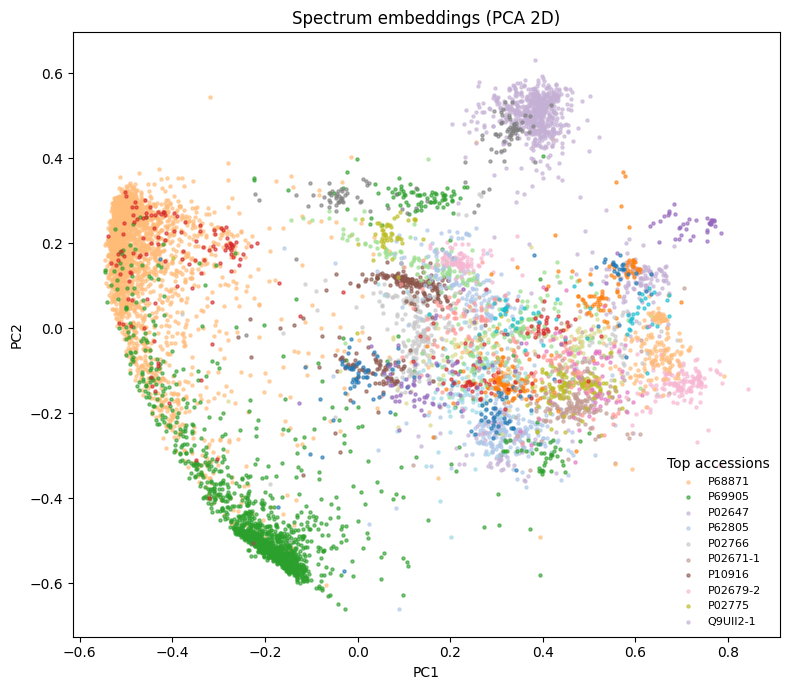

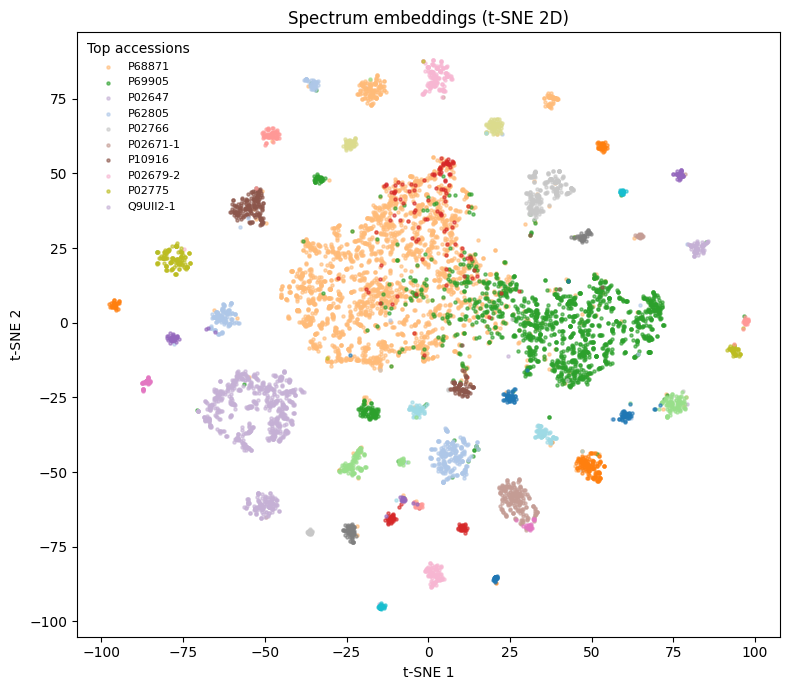

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter

# ---------------------------------------------------
# 1) Choose a subset of training embeddings to plot
# ---------------------------------------------------
# train_emb: (N_train, emb_dim)
# train_accid: (N_train,)
# unique_acc_top: array/list of accession strings

N_TOTAL = train_emb.shape[0]
N_VIS   = 8000   # how many points to visualize (change if you like)

if N_TOTAL <= N_VIS:
    vis_idx = np.arange(N_TOTAL)
else:
    vis_idx = np.random.choice(N_TOTAL, size=N_VIS, replace=False)

X = train_emb[vis_idx]        # (N_vis, emb_dim)
y = train_accid[vis_idx]      # (N_vis,)

print(f"Visualizing {X.shape[0]} points out of {N_TOTAL} total.")

# ---------------------------------------------------
# 2) Pick the most frequent labels for clearer legend
# ---------------------------------------------------
label_counts = Counter(y)
# sort labels by frequency (descending)
sorted_labels = [lab for lab, _ in label_counts.most_common()]

# we will only annotate the top K labels in the legend
K_LEGEND = 10
legend_labels = sorted_labels[:K_LEGEND]

# ---------------------------------------------------
# 3) PCA to 2D
# ---------------------------------------------------
print("Running PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# ---------------------------------------------------
# 4) t-SNE (on PCA 50D for speed & stability)
# ---------------------------------------------------
print("Running PCA->t-SNE (this can take a bit)...")
pca_50 = PCA(n_components=min(50, X.shape[1]), random_state=42)
X_50 = pca_50.fit_transform(X)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    init="random",
    random_state=42,
)
X_tsne = tsne.fit_transform(X_50)

# ---------------------------------------------------
# 5) Helper: color map per label
# ---------------------------------------------------
# use a continuous colormap and map integer labels into [0,1]
cmap = plt.get_cmap("tab20")  # good for up to ~20 distinct colors

def label_to_color(label):
    # wrap around tab20 if more than 20 classes
    return cmap(label % 20)

# ---------------------------------------------------
# 6) Plot PCA
# ---------------------------------------------------
plt.figure(figsize=(8, 7))
for lab in sorted_labels:
    mask = (y == lab)
    if not np.any(mask):
        continue
    pts = X_pca[mask]
    color = label_to_color(lab)
    # Only put label in legend for top K_LEGEND most frequent
    label_str = unique_acc_top[lab] if lab in legend_labels else None
    plt.scatter(pts[:, 0], pts[:, 1], s=5, alpha=0.6, c=[color], label=label_str)

# Build legend only from non-None labels
handles, labels = plt.gca().get_legend_handles_labels()
if handles:
    plt.legend(handles, labels, fontsize=8, frameon=False, title="Top accessions", loc="best")

plt.title("Spectrum embeddings (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 7) Plot t-SNE
# ---------------------------------------------------
plt.figure(figsize=(8, 7))
for lab in sorted_labels:
    mask = (y == lab)
    if not np.any(mask):
        continue
    pts = X_tsne[mask]
    color = label_to_color(lab)
    label_str = unique_acc_top[lab] if lab in legend_labels else None
    plt.scatter(pts[:, 0], pts[:, 1], s=5, alpha=0.6, c=[color], label=label_str)

handles, labels = plt.gca().get_legend_handles_labels()
if handles:
    plt.legend(handles, labels, fontsize=8, frameon=False, title="Top accessions", loc="best")

plt.title("Spectrum embeddings (t-SNE 2D)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


Confusion matrix

Using device: cpu
Loading HDF5: F:\20251115\spectra_h5\combined_annotated_filtered.h5
Total spectra after filtering empty accessions: 398060
Any NaN left in ms2_lib? False
Any inf left in ms2_lib? False
Spectra shape (N, n_bins) = (398060, 1600)
Total unique accessions before top-50 filter: 1815
Using top 50 accessions by frequency.
Spectra after top-50 filter: 305571
Number of unique accessions after top-50 filter: 50
Final spectra shape (N, n_bins) = (305571, 1600)
Train spectra: 244456, Test spectra: 61115

Loading trained model from: contrastive_spectrum_encoder.pth
Embedding dimension from checkpoint: 64
Model loaded and set to eval mode.

Embedding all train spectra...
Train embeddings shape: (244456, 64)

Selecting up to 100 test spectra per class for evaluation...
Balanced evaluation set shape: (5000, 1600) (5000,)
Embedding evaluation spectra...
eval_emb shape: (5000, 64)

Running memory-safe 10-NN predictions...
Processed 500/5000 eval spectra...
Processed 1000/5000 eval spec

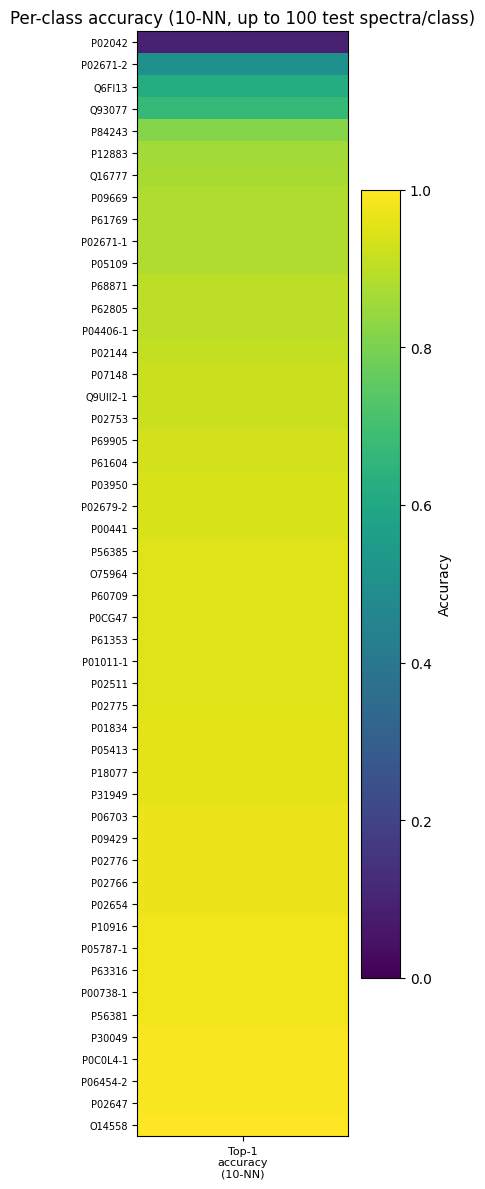

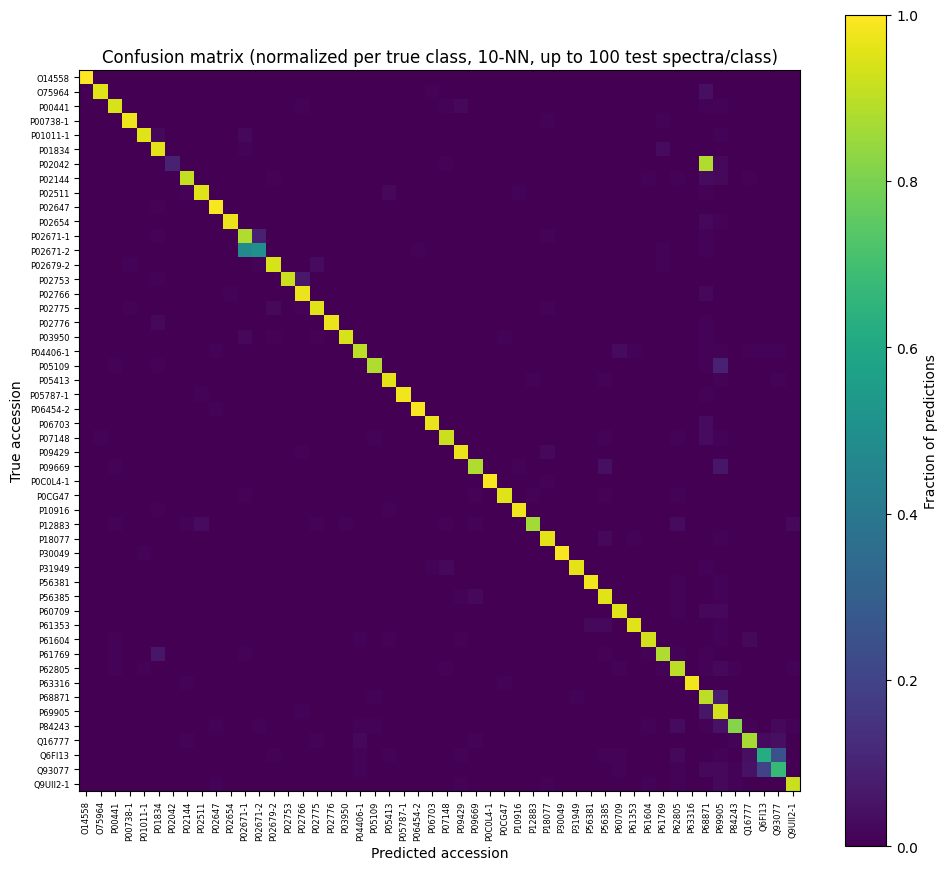

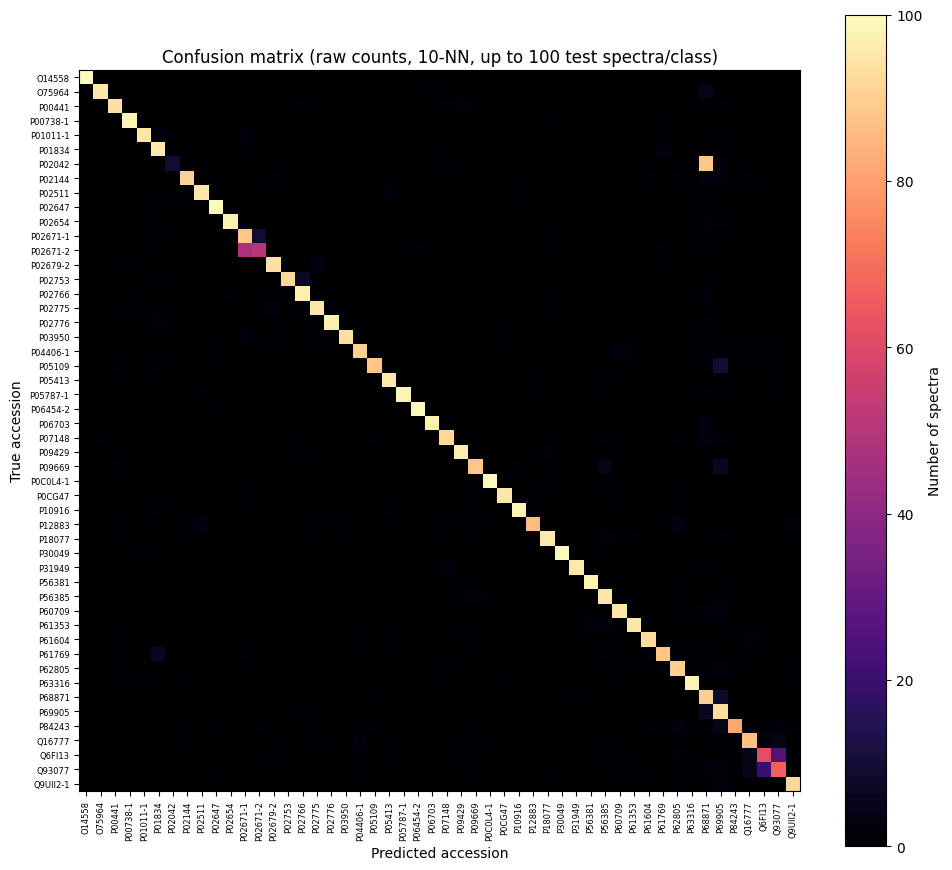

In [37]:
"""
Full pipeline:

1) Load HDF5 databank (combined_annotated_filtered.h5)
2) Preprocess and restrict to top-50 most frequent accessions
3) 80/20 train-test split
4) Load trained contrastive encoder model from contrastive_spectrum_encoder.pth
5) Embed train spectra -> build embedding index
6) From test set, select up to 100 spectra per class (50 classes)
7) Embed eval spectra
8) Run memory-safe 10-NN majority vote
9) Compute per-class accuracy
10) Plot:
    - 50x1 per-class accuracy heatmap
    - 50x50 confusion matrix (normalized + raw counts)
"""

import os
import h5py
import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
H5_PATH    = r"F:\20251115\spectra_h5\combined_annotated_filtered.h5"
MODEL_PATH = "contrastive_spectrum_encoder.pth"

DEVICE          = "cuda" if torch.cuda.is_available() else "cpu"
TOP_K_CLASSES   = 50      # top 50 accessions by frequency
TRAIN_FRACTION  = 0.8     # 80/20 split
PER_CLASS_EVAL  = 100     # up to 100 test spectra per class
K_NEIGHBORS     = 10      # 10-NN classifier
RANDOM_SEED     = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("Using device:", DEVICE)

# =========================
# 1) Load & clean HDF5
# =========================
print("Loading HDF5:", H5_PATH)
with h5py.File(H5_PATH, "r") as h5:
    acc_raw = h5["Accession"][:]   # dtype=object
    ms2_lib = h5["ms2_lib"][:]     # (N, n_bins)

# Decode accessions
acc_str = np.array([
    a.decode() if isinstance(a, (bytes, bytearray)) else str(a)
    for a in acc_raw
])

# Filter out empty accessions
mask_nonempty = acc_str != ""
acc_str = acc_str[mask_nonempty]
ms2_lib = ms2_lib[mask_nonempty]

print("Total spectra after filtering empty accessions:", len(acc_str))

# Clean spectra
ms2_lib = ms2_lib.astype(np.float32)
bad_mask = ~np.isfinite(ms2_lib)
if bad_mask.any():
    print("Found NaN/inf in ms2_lib, replacing with 0")
    ms2_lib[bad_mask] = 0.0

# Per-spectrum max normalization (same as training)
max_intensity = np.max(ms2_lib, axis=1, keepdims=True)
max_intensity[max_intensity == 0] = 1.0
ms2_lib = ms2_lib / max_intensity

print("Any NaN left in ms2_lib?", np.isnan(ms2_lib).any())
print("Any inf left in ms2_lib?", np.isinf(ms2_lib).any())
N_total, n_bins = ms2_lib.shape
print(f"Spectra shape (N, n_bins) = {ms2_lib.shape}")

# =========================
# 2) Restrict to top-50 accessions
# =========================
all_unique_acc, all_acc_ids = np.unique(acc_str, return_inverse=True)
counts = np.bincount(all_acc_ids)
print("Total unique accessions before top-50 filter:", len(all_unique_acc))

top_k = min(TOP_K_CLASSES, len(all_unique_acc))
top_class_indices = np.argsort(-counts)[:top_k]  # indices of most frequent classes
top_class_set = set(top_class_indices.tolist())

print(f"Using top {top_k} accessions by frequency.")

mask_top = np.isin(all_acc_ids, list(top_class_set))
acc_str_top = acc_str[mask_top]
ms2_lib_top = ms2_lib[mask_top]

print("Spectra after top-50 filter:", len(acc_str_top))

# Re-encode labels compactly 0..(n_classes-1)
unique_acc_top, acc_ids_top = np.unique(acc_str_top, return_inverse=True)
n_classes = len(unique_acc_top)
print("Number of unique accessions after top-50 filter:", n_classes)

N, n_bins = ms2_lib_top.shape
print(f"Final spectra shape (N, n_bins) = {ms2_lib_top.shape}")

# =========================
# 3) Train / test split (80/20)
# =========================
indices = np.arange(N)
np.random.shuffle(indices)
split = int(TRAIN_FRACTION * N)
train_idx = indices[:split]
test_idx  = indices[split:]

train_ms2   = ms2_lib_top[train_idx]
train_accid = acc_ids_top[train_idx]

test_ms2    = ms2_lib_top[test_idx]
test_accid  = acc_ids_top[test_idx]

print(f"Train spectra: {len(train_ms2)}, Test spectra: {len(test_ms2)}")

# =========================
# 4) Define model & load checkpoint
# =========================
class SpectrumEncoder(nn.Module):
    def __init__(self, n_bins, emb_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_bins, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, emb_dim),
        )

    def forward(self, x):
        z = self.net(x)
        # Safety guard
        if torch.isnan(z).any():
            print("Warning: NaN detected in encoder output, applying nan_to_num.")
            z = torch.nan_to_num(z, nan=0.0, posinf=1e6, neginf=-1e6)
        z = F.normalize(z, dim=-1)
        return z

print("\nLoading trained model from:", MODEL_PATH)
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=False)

emb_dim_ckpt = checkpoint["emb_dim"]
print("Embedding dimension from checkpoint:", emb_dim_ckpt)

model = SpectrumEncoder(n_bins=n_bins, emb_dim=emb_dim_ckpt).to(DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
print("Model loaded and set to eval mode.")

# =========================
# 5) Embed train spectra -> build embedding index
# =========================
def embed_batch(model, spectra_np, device, batch_size=2048):
    model.eval()
    out = []
    with torch.no_grad():
        for i in range(0, len(spectra_np), batch_size):
            xb = torch.tensor(
                spectra_np[i:i+batch_size],
                dtype=torch.float32,
                device=device
            )
            zb = model(xb)
            out.append(zb.cpu().numpy())
    return np.concatenate(out, axis=0)

print("\nEmbedding all train spectra...")
train_emb = embed_batch(model, train_ms2, DEVICE)
train_labels = train_accid.copy()
print("Train embeddings shape:", train_emb.shape)

# =========================
# 6) Build a balanced evaluation set (up to 100 test spectra/class)
# =========================
def select_up_to_100_per_class(ms2, labels, n_classes=50, per_class=100):
    all_idx = []
    for c in range(n_classes):
        idx_c = np.where(labels == c)[0]
        if len(idx_c) == 0:
            print(f"Class {c} ({unique_acc_top[c]}) has 0 test samples -> skipping.")
            continue
        if len(idx_c) < per_class:
            print(f"Class {c} ({unique_acc_top[c]}) has only {len(idx_c)} test samples -> using all.")
            chosen = idx_c
        else:
            chosen = np.random.choice(idx_c, size=per_class, replace=False)
        all_idx.append(chosen)
    all_idx = np.concatenate(all_idx)
    return ms2[all_idx], labels[all_idx]

print("\nSelecting up to 100 test spectra per class for evaluation...")
eval_ms2, eval_labels = select_up_to_100_per_class(
    test_ms2,
    test_accid,
    n_classes=n_classes,
    per_class=PER_CLASS_EVAL
)
print("Balanced evaluation set shape:", eval_ms2.shape, eval_labels.shape)

print("Embedding evaluation spectra...")
eval_emb = embed_batch(model, eval_ms2, DEVICE)
print("eval_emb shape:", eval_emb.shape)

# =========================
# 7) Memory-safe 10-NN majority vote classifier
# =========================
def knn_predict_10nn_memory_safe(query_emb, db_emb, db_labels, k=10):
    """
    query_emb: (N_eval, D)
    db_emb:    (N_train, D)
    db_labels: (N_train,)
    Returns:   preds (N_eval,)
    """
    N_eval = query_emb.shape[0]
    preds = np.zeros(N_eval, dtype=int)

    for i in range(N_eval):
        q = query_emb[i]          # (D,)
        sims = db_emb @ q         # (N_train,) cosine sims (embeddings normalized)

        k_eff = min(k, len(db_emb))
        nn_idx = np.argpartition(-sims, k_eff - 1)[:k_eff]
        nn_labels = db_labels[nn_idx]

        cnt = Counter(nn_labels)
        preds[i] = cnt.most_common(1)[0][0]

        if (i + 1) % 500 == 0 or i == N_eval - 1:
            print(f"Processed {i+1}/{N_eval} eval spectra...")

    return preds

print("\nRunning memory-safe 10-NN predictions...")
eval_pred = knn_predict_10nn_memory_safe(eval_emb, train_emb, train_labels, k=K_NEIGHBORS)
print("Predictions done.")

# =========================
# 8) Per-class accuracy (balanced eval)
# =========================
per_class_acc = np.zeros(n_classes)
counts = np.zeros(n_classes, dtype=int)

for c in range(n_classes):
    mask = (eval_labels == c)
    n = mask.sum()
    counts[c] = n
    if n == 0:
        per_class_acc[c] = np.nan
    else:
        per_class_acc[c] = (eval_pred[mask] == c).sum() / n

# sort by accuracy
sorted_idx = np.argsort(np.nan_to_num(per_class_acc, nan=-1))
sorted_acc = per_class_acc[sorted_idx]
sorted_names = [unique_acc_top[i] for i in sorted_idx]
sorted_counts = counts[sorted_idx]

print("\nBalanced (up to 100 per class) 10-NN accuracy:")
for name, acc, n in zip(sorted_names, sorted_acc, sorted_counts):
    acc_str = "NA" if np.isnan(acc) else f"{acc:.3f}"
    print(f"{name:20s}  | n={n:4d} | acc={acc_str}")

# =========================
# 9) Per-class accuracy heatmap (50 x 1)
# =========================
acc_matrix = sorted_acc.reshape(-1, 1)

fig, ax = plt.subplots(figsize=(4, 12))
im = ax.imshow(acc_matrix, aspect="auto", vmin=0.0, vmax=1.0, cmap="viridis")

ax.set_yticks(np.arange(len(sorted_names)))
ax.set_yticklabels(sorted_names, fontsize=7)

ax.set_xticks([0])
ax.set_xticklabels(["Top-1\naccuracy\n(10-NN)"], fontsize=8)

plt.colorbar(im, ax=ax, label="Accuracy")
plt.title("Per-class accuracy (10-NN, up to 100 test spectra/class)")
plt.tight_layout()
plt.show()

# =========================
# 10) Confusion matrix (50 x 50)
# =========================
# Build confusion matrix (true x predicted)
conf = np.zeros((n_classes, n_classes), dtype=int)
for t, p in zip(eval_labels, eval_pred):
    if 0 <= t < n_classes and 0 <= p < n_classes:
        conf[t, p] += 1

row_sums = conf.sum(axis=1, keepdims=True)
row_sums_safe = row_sums.copy()
row_sums_safe[row_sums_safe == 0] = 1

conf_norm = conf / row_sums_safe

# Plot normalized confusion matrix
fig, ax = plt.subplots(figsize=(10, 9))
im2 = ax.imshow(conf_norm, interpolation='nearest', cmap='viridis', vmin=0.0, vmax=1.0)

ax.set_xticks(np.arange(n_classes))
ax.set_yticks(np.arange(n_classes))

ax.set_xticklabels(unique_acc_top, rotation=90, fontsize=6)
ax.set_yticklabels(unique_acc_top, fontsize=6)

ax.set_xlabel("Predicted accession", fontsize=10)
ax.set_ylabel("True accession", fontsize=10)
ax.set_title("Confusion matrix (normalized per true class, 10-NN, up to 100 test spectra/class)")

cbar = plt.colorbar(im2, ax=ax)
cbar.set_label("Fraction of predictions", rotation=90)

plt.tight_layout()
plt.show()

# Plot raw-count confusion matrix
fig, ax = plt.subplots(figsize=(10, 9))
im3 = ax.imshow(conf, interpolation='nearest', cmap='magma')

ax.set_xticks(np.arange(n_classes))
ax.set_yticks(np.arange(n_classes))

ax.set_xticklabels(unique_acc_top, rotation=90, fontsize=6)
ax.set_yticklabels(unique_acc_top, fontsize=6)

ax.set_xlabel("Predicted accession", fontsize=10)
ax.set_ylabel("True accession", fontsize=10)
ax.set_title("Confusion matrix (raw counts, 10-NN, up to 100 test spectra/class)")

cbar2 = plt.colorbar(im3, ax=ax)
cbar2.set_label("Number of spectra", rotation=90)

plt.tight_layout()
plt.show()


most confused

In [38]:
def get_top_confusions(conf_norm, class_names, top_n=10, threshold=0.01):
    """
    conf_norm: (C, C) row-normalized confusion matrix
    class_names: list of accession strings
    top_n: number of confusions to report
    threshold: minimum fraction to consider (e.g., ignore tiny noise)
    """

    C = conf_norm.shape[0]
    conf_list = []

    for i in range(C):
        for j in range(C):
            if i == j:
                continue  # skip diagonal
            frac = conf_norm[i, j]
            if frac >= threshold:
                conf_list.append((frac, i, j))

    # Sort descending by confusion value
    conf_list.sort(reverse=True)

    print(f"\nTop {top_n} confusions (off-diagonal > {threshold}):\n")
    for k in range(min(top_n, len(conf_list))):
        frac, true_idx, pred_idx = conf_list[k]
        print(
            f"TRUE {class_names[true_idx]:10s}  →  predicted {class_names[pred_idx]:10s} "
            f" ({frac:.3f})"
        )

    return conf_list

# Run it:
top_confusions = get_top_confusions(conf_norm, unique_acc_top, top_n=10, threshold=0.05)



Top 10 confusions (off-diagonal > 0.05):

TRUE P02042      →  predicted P68871      (0.880)
TRUE P02671-2    →  predicted P02671-1    (0.470)
TRUE Q6FI13      →  predicted Q93077      (0.250)
TRUE Q93077      →  predicted Q6FI13      (0.200)
TRUE P05109      →  predicted P69905      (0.090)
TRUE P02671-1    →  predicted P02671-2    (0.090)
TRUE P68871      →  predicted P69905      (0.080)
TRUE P02753      →  predicted P02766      (0.070)
TRUE P69905      →  predicted P68871      (0.060)
TRUE P61769      →  predicted P01834      (0.060)
